### Import Modules

In [10]:
import os
import sys
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
import portion as P
import itertools as it
import csv
from pprint import pprint
from pytictoc import TicToc
from tqdm import tqdm
import traceback
import math
import matplotlib.colors as mcolors

# ******************************* User Settings *******************************
database = "/home/wmnlab/D/database/"
date = "2022-12-20"
devices = sorted([
    # "sm00",
    # "sm01",
    # "sm02",
    # "sm03",
    # "sm04",
    "sm05",
    "sm06",
    "sm07",
    "sm08",
    # "qc00",
    # "qc01",
    # "qc02",
    # "qc03",
])
exps = {  # experiment_name: (number_of_experiment_rounds, list_of_experiment_round)
            # If the list is None, it will not list as directories.
            # If the list is empty, it will list all directories in the current directory by default.
            # If the number of experiment times != the length of existing directories of list, it would trigger warning and skip the directory.
    # "tsync": (1, None),
    # "_Bandlock_Udp": (4, ["#01", "#02", "#03", "#04"]),
    # "_Bandlock_Udp": (4, ["#03", "#04", "#05", "#06"]),
    # "_Bandlock_Udp": (4, []),
    # "_Bandlock_Udp": (6, []),
    "_Bandlock_Udp_B1_B3":  (6, []),
    # "_Bandlock_Udp_B3_B28": (4, []),
    # "_Bandlock_Udp_B28_B1": (4, []),
    # "_Bandlock_Udp_B1_B3":  (4, []),
    # "_Bandlock_Udp_B3_B7":  (4, []),
    # "_Bandlock_Udp_B7_B8":  (4, []),
    # "_Bandlock_Udp_B8_B1":  (4, []),
}

class Payload:
    LENGTH = 250              # (Bytes)
    TAG = "000425d401df5e76"  # 2 71828 3 1415926 (hex)            : 8-bytes
    OFS_TIME = (16, 24)       # epoch time of 'yyyy/mm/dd hh:mm:ss': 4-bytes
    OFS_USEC = (24, 32)       # microsecond (usec)                 : 4-bytes
    OFS_SEQN = (32, 40)       # sequence number (start from 1)     : 4-bytes
class ServerIP:
    PUBLIC = "140.112.20.183"  # 2F    
    PRIVATE = "192.168.1.251"  # 2F
    # PRIVATE = "192.168.1.248"  # 2F previous

# DATA_RATE = 1000e3  # bits-per-second
# PKT_RATE = DATA_RATE / Payload.LENGTH / 8  # packets-per-second
# print("packet_rate (pps):", PKT_RATE, "\n")
# *****************************************************************************

### Utils Functions

In [11]:
# ****************************** Utils Functions ******************************
def makedir(dirpath, mode=0):  # mode=1: show message; mode=0: hide message
    if os.path.isdir(dirpath):
        if mode:
            print("mkdir: cannot create directory '{}': directory has already existed.".format(dirpath))
        return
    ### recursively make directory
    _temp = []
    while not os.path.isdir(dirpath):
        _temp.append(dirpath)
        dirpath = os.path.dirname(dirpath)
    while _temp:
        dirpath = _temp.pop()
        print("mkdir", dirpath)
        os.mkdir(dirpath)

def interp(x, y, ratio):
    """
    Interpolation

    Args:
        x, y (datetime.datetime): x < y
        ratio (float): a decimal numeral in a range [0, 1]; 0 means break at x, 1 means break at y.
    Returns:
        (datetime.datetime): breakpoint of interpolation
    """
    return x + (y - x) * ratio

def is_disjoint(set1, set2):
    """
    Check if two sets are disjoint.
    """
    return (set1 & set2).empty

def pairwise_disjoint(set_list):
    """
    Check if all sets in the list are pairwise disjoint.
    """
    pair_list = list(it.combinations(set_list, 2))
    for item in pair_list:
        if not is_disjoint(item[0], item[1]):
            return False
    return True

def union_all(set_list):
    """
    Union all sets in the list.
    """
    _temp = P.empty()
    for _set in set_list:
        _temp = _temp | _set
    return _temp

def get_length(intervals):
    """
    Get total length of a set of intervals.
    """
    if intervals.empty:
        return 0
    sum = 0
    for s in intervals:
        sum += (s.upper - s.lower) / dt.timedelta(seconds=1)
    return round(sum, 3)
# *****************************************************************************

### Plotting

In [12]:
figdir = os.path.join("/home/wmnlab/Desktop/Jackbedford/wmnl-handoff-research/analysis/2022-12-27/figure", "9")
makedir(os.path.join(figdir))

mkdir /home/wmnlab/Desktop/Jackbedford/wmnl-handoff-research/analysis/2022-12-27/figure/9


In [13]:
database = "/home/wmnlab/D/database/"
exps = { "2022-12-20": 
            {  # experiment_name: (number_of_experiment_rounds, list_of_experiment_round)
                # "_Bandlock_Udp_B1_B3":  (1, ["#01",]),
                # "_Bandlock_Udp_B1_B3":  (2, ["#01", "#02",]),
                "_Bandlock_Udp_B1_B3":  (6, ["#01", "#02", "#03", "#04", "#05", "#06"]),
            },
        "2022-12-22":
            {
                "_Bandlock_Udp_B1_B3":  (3, ["#02", "#03", "#04",]),
                "_Bandlock_Udp_B3_B7":  (4, ["#01", "#02", "#03", "#04",]),
                "_Bandlock_Udp_B7_B8":  (4, ["#01", "#02", "#03", "#04",]),
                "_Bandlock_Udp_B8_B1":  (4, ["#01", "#02", "#03", "#04",]),
            },
}
# devices = ["sm05",]
# setnames = ["all",]
devices = ["sm05", "sm06", "sm07", "sm08"]
setnames = ["all", "b1", "b3", "b1b3"]

handover_types_0 = "lte_handover,SN_addition,SN_removal,endc_SN_change,endc_MN_change,endc_MNSN_change,lte2endc_MN_change,endc2lte_MN_change".split(',')
handover_types_1 = "SN_change_only,Intra_frequency,Inter_frequency".split(',')
handover_types_2 = "SN_change_only,Intra_sector,Intra_eNB,Inter_eNB".split(',')
handover_fail_types = "scg_failure,radio_link_failure,nas_recovery".split(',')
handover_types = handover_types_0 + handover_fail_types

first_time = 1
lodict = {}
dfs = pd.DataFrame()
type_names = []
for date, _exps in exps.items():
    for expr, (times, traces) in _exps.items():
        for k, (dev, stg) in enumerate(zip(devices, setnames)):
            # print('@'.join([stg, dev]))
            # print("----------------------")
            for trace in traces:
                """"""
                # source_dir = os.path.join(database, date, expr, dev, trace, "statistics", "classify-bilateral")
                # df = pd.read_csv(os.path.join(source_dir, "uplk-loss", "uplk_loss_classify_1_3.csv"), index_col=0)
                # df = pd.read_csv(os.path.join(source_dir, "dnlk-loss", "dnlk_loss_classify_1_3.csv"), index_col=0)
                # df = pd.read_csv(os.path.join(source_dir, "uplk-loss", "uplk_loss_classify_1.csv"), index_col=0)
                source_dir = os.path.join(database, date, expr, dev, trace, "data")
                df = pd.read_csv(os.path.join(source_dir, "diag_log_ho-info_new.csv"))
                """"""
                df = df[df["handoff_state"] == "start"]
                dfs = pd.concat([dfs, df], ignore_index=True)

display(dfs)
# pprint(lodict, sort_dicts=False, width=100, compact=True)

,Timestamp,type_id,handoff_type,handoff_state,handoff_duration,eNB.ID,CID,PCI,EARFCN,NR_PCI,NR_ARFCN,handoff_type.1,handoff_type.2
0,2022-12-20 15:59:35.729337,LTE_RRC_OTA_Packet,endc_SN_change,start,0.015106,213133.0,23.0,178,1750.0,178,631000,SN_change_only,SN_change_only
1,2022-12-20 15:59:40.999392,LTE_RRC_OTA_Packet,endc_SN_change,start,0.015063,213133.0,23.0,178,1750.0,394,631000,SN_change_only,SN_change_only
2,2022-12-20 16:01:25.813990,LTE_RRC_OTA_Packet,lte_handover,start,0.036229,213133.0,23.0,178,1750.0,178,631000,Intra_frequency,Inter_eNB
3,2022-12-20 16:01:26.325419,LTE_RRC_OTA_Packet,lte2endc_MN_change,start,0.038949,212123.0,33.0,122,1750.0,-,-,Intra_frequency,Intra_sector
4,2022-12-20 16:01:35.643101,LTE_RRC_OTA_Packet,lte_handover,start,0.038818,212123.0,33.0,122,1750.0,122,631000,Intra_frequency,Intra_sector
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2035,2022-12-22 17:20:03.221665,LTE_RRC_OTA_Packet,lte_handover,start,0.017182,212123.0,26.0,130,525.0,-,-,Intra_frequency,Inter_eNB
2036,2022-12-22 17:20:06.513024,LTE_RRC_OTA_Packet,lte_handover,start,0.013655,213133.0,26.0,178,525.0,-,-,Intra_frequency,Inter_eNB
2037,2022-12-22 17:20:07.633187,LTE_RRC_OTA_Packet,lte_handover,start,0.016348,212190.0,26.0,394,525.0,-,-,Intra_frequency,Inter_eNB
2038,2022-12-22 17:20:17.516399,LTE_RRC_OTA_Packet,lte_handover,start,0.015245,212123.0,26.0,130,525.0,-,-,Intra_frequency,Intra_eNB


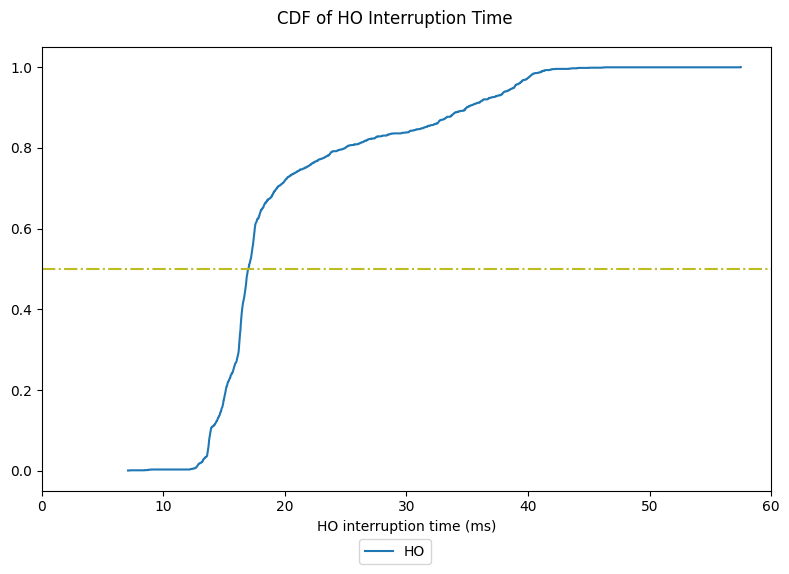

In [18]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 5.5))
fig.suptitle("CDF of HO Interruption Time")

data = [item*1000 for item in dfs["handoff_duration"].array]
# print(data)
count, bins_count = np.histogram(data, bins=5000)
# print(count, bins_count)
pdf = count / sum(count)
cdf = np.cumsum(pdf)
# ax[i].plot(bins_count[1:], cdf, label=event_name)
handle, = ax.plot(bins_count[1:], cdf, label='HO')

axbox = ax.get_position()
fig.legend(
    # handles=handles, labels=labels,
    loc='lower center', bbox_to_anchor=[0, axbox.y0-0.15,1,1], ncol=2)

ax.set_xlabel("HO interruption time (ms)")
ax.set_xlim(left=0)

ax.axhline(0.5, c='tab:olive', linestyle='-.')

fig.tight_layout()
fig.savefig(os.path.join(figdir, "1.png"), bbox_inches='tight')
fig.show()

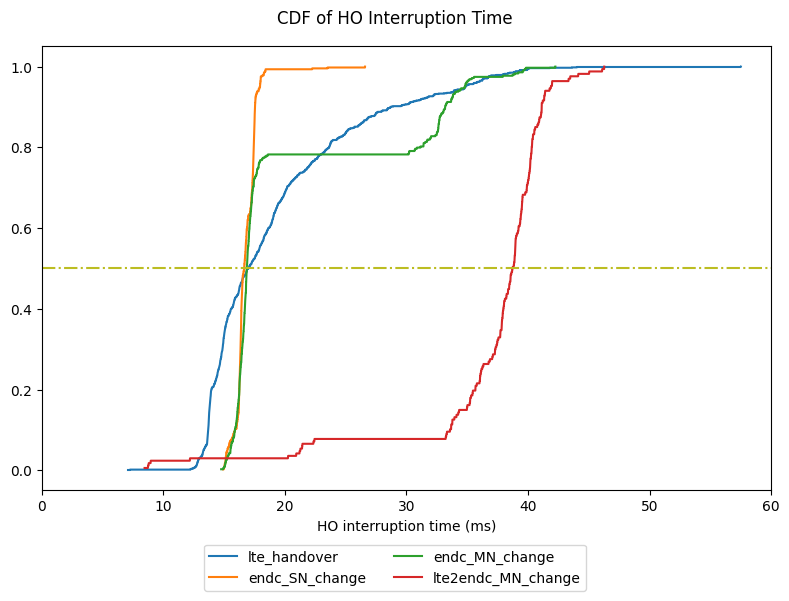

In [19]:
handover_types_0 = "lte_handover,SN_addition,SN_removal,endc_SN_change,endc_MN_change,endc_MNSN_change,lte2endc_MN_change,endc2lte_MN_change".split(',')
colors = ['tab:blue', 'tab:purple', 'tab:brown', 'tab:orange', 'tab:green', 'tab:pink', 'tab:red', 'tab:gray', 'tab:olive', 'tab:cyan']

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 5.5))
fig.suptitle("CDF of HO Interruption Time")

labels = handover_types_0
handles = [None]*len(labels)
for j, type_name in enumerate(handover_types_0):
    data = [item*1000 for item in dfs[dfs["handoff_type"] == type_name]["handoff_duration"].array]
    if len(data) == 0:
        # _never_occurs.add(type_name)
        continue
    # print(data)
    count, bins_count = np.histogram(data, bins=5000)
    # print(count, bins_count)
    pdf = count / sum(count)
    cdf = np.cumsum(pdf)
    # ax[i].plot(bins_count[1:], cdf, label=event_name)
    handles[j], = ax.plot(bins_count[1:], cdf, c=colors[j])

ax.set_xlabel("HO interruption time (ms)")
ax.set_xlim(left=0)

# ax.axvline(1, c='tab:pink', linestyle='-.')
# ax.axvline(30, c='tab:pink', linestyle='-.')
# ax.axhline(0.9, c='tab:olive', linestyle='-.')
ax.axhline(0.5, c='tab:olive', linestyle='-.')

axbox = ax.get_position()
# print(axbox)
labels = [item for key, item in zip(handles, labels) if key != None]
handles = [item for item in handles if item != None]
fig.legend(
    handles=handles, labels=labels,
    loc='lower center', bbox_to_anchor=[0, axbox.y0-0.2,1,1], ncol=2)

fig.tight_layout()
fig.savefig(os.path.join(figdir, "2.png"), bbox_inches='tight')
fig.show()

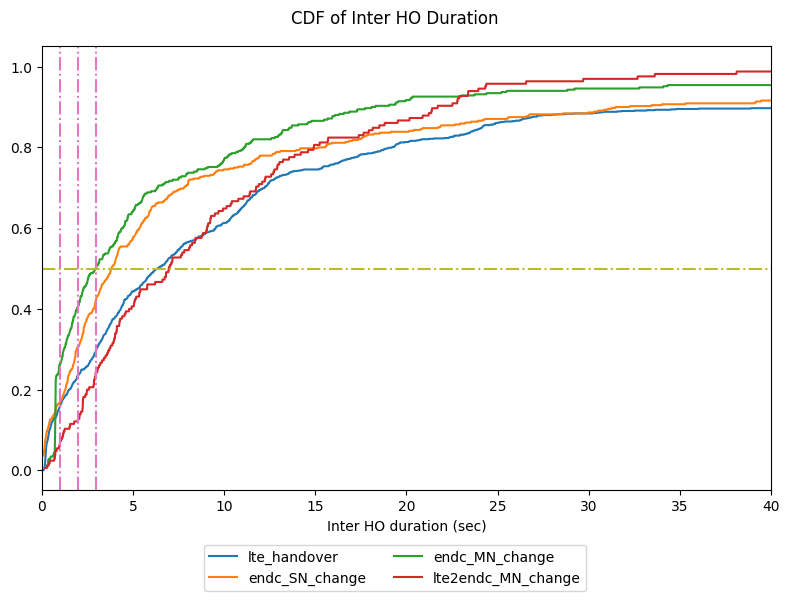

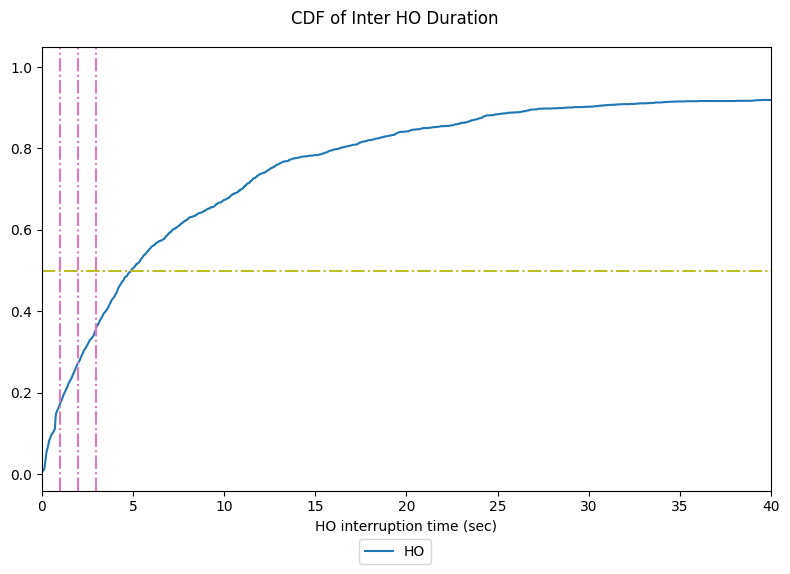

In [22]:
database = "/home/wmnlab/D/database/"
exps = { "2022-12-20": 
            {  # experiment_name: (number_of_experiment_rounds, list_of_experiment_round)
                # "_Bandlock_Udp_B1_B3":  (1, ["#01",]),
                # "_Bandlock_Udp_B1_B3":  (2, ["#01", "#02",]),
                "_Bandlock_Udp_B1_B3":  (6, ["#01", "#02", "#03", "#04", "#05", "#06"]),
            },
        "2022-12-22":
            {
                "_Bandlock_Udp_B1_B3":  (3, ["#02", "#03", "#04",]),
                "_Bandlock_Udp_B3_B7":  (4, ["#01", "#02", "#03", "#04",]),
                "_Bandlock_Udp_B7_B8":  (4, ["#01", "#02", "#03", "#04",]),
                "_Bandlock_Udp_B8_B1":  (4, ["#01", "#02", "#03", "#04",]),
            },
}
# devices = ["sm05",]
# setnames = ["all",]
devices = ["sm05", "sm06", "sm07", "sm08"]
setnames = ["all", "b1", "b3", "b1b3"]

handover_types_0 = "lte_handover,SN_addition,SN_removal,endc_SN_change,endc_MN_change,endc_MNSN_change,lte2endc_MN_change,endc2lte_MN_change".split(',')
handover_types_1 = "SN_change_only,Intra_frequency,Inter_frequency".split(',')
handover_types_2 = "SN_change_only,Intra_sector,Intra_eNB,Inter_eNB".split(',')
handover_fail_types = "scg_failure,radio_link_failure,nas_recovery".split(',')
handover_types = handover_types_0 + handover_fail_types

ho_duration_list = [[] for i in range(len(handover_types_0))]
for date, _exps in exps.items():
    for expr, (times, traces) in _exps.items():
        for k, (dev, stg) in enumerate(zip(devices, setnames)):
            # print('@'.join([stg, dev]))
            # print("----------------------")
            for trace in traces:
                """"""
                source_dir = os.path.join(database, date, expr, dev, trace, "data")
                df = pd.read_csv(os.path.join(source_dir, "diag_log_ho-info_new.csv"))
                df['Timestamp'] = pd.to_datetime(df['Timestamp'])
                df['newcol'] = pd.Series(dtype=object)
                for i in range(len(df)):
                    if df.at[i, 'handoff_state'] == 'end' and i != len(df)-1:
                        df.at[i, 'newcol'] = (df.at[i+1, 'Timestamp'] - df.at[i, 'Timestamp']).total_seconds()
                # print(df)
                """"""
                df = df[df['handoff_state'] == 'end']
                df = df.dropna()
                # print(df)
                for i, type0 in enumerate(handover_types_0):
                    ho_duration_list[i] = [*ho_duration_list[i], *list(df[df['handoff_type'] == type0]['newcol'].array)]

handover_types_0 = "lte_handover,SN_addition,SN_removal,endc_SN_change,endc_MN_change,endc_MNSN_change,lte2endc_MN_change,endc2lte_MN_change".split(',')
colors = ['tab:blue', 'tab:purple', 'tab:brown', 'tab:orange', 'tab:green', 'tab:pink', 'tab:red', 'tab:gray', 'tab:olive', 'tab:cyan']

_data = []

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 5.5))
fig.suptitle("CDF of Inter HO Duration")

labels = handover_types_0
handles = [None]*len(labels)
for j, type_name in enumerate(handover_types_0):
    data = ho_duration_list[j]
    _data = [*_data, *ho_duration_list[j]]
    if len(data) == 0:
        # _never_occurs.add(type_name)
        continue
    # print(data)
    count, bins_count = np.histogram(data, bins=5000)
    # print(count, bins_count)
    pdf = count / sum(count)
    cdf = np.cumsum(pdf)
    # ax[i].plot(bins_count[1:], cdf, label=event_name)
    handles[j], = ax.plot(bins_count[1:], cdf, c=colors[j])

ax.set_xlabel("Inter HO duration (sec)")
ax.set_xlim(left=0, right=40)

axbox = ax.get_position()
# print(axbox)
labels = [item for key, item in zip(handles, labels) if key != None]
handles = [item for item in handles if item != None]
fig.legend(
    handles=handles, labels=labels,
    loc='lower center', bbox_to_anchor=[0, axbox.y0-0.2,1,1], ncol=2)

ax.axvline(1, c='tab:pink', linestyle='-.')
ax.axvline(2, c='tab:pink', linestyle='-.')
ax.axvline(3, c='tab:pink', linestyle='-.')
# ax.axhline(0.9, c='tab:olive', linestyle='-.')
ax.axhline(0.5, c='tab:olive', linestyle='-.')

fig.tight_layout()
fig.savefig(os.path.join(figdir, "3.png"), bbox_inches='tight')
fig.show()

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 5.5))
fig.suptitle("CDF of Inter HO Duration")

data = _data
# print(data)
count, bins_count = np.histogram(data, bins=5000)
# print(count, bins_count)
pdf = count / sum(count)
cdf = np.cumsum(pdf)
# ax[i].plot(bins_count[1:], cdf, label=event_name)
handle, = ax.plot(bins_count[1:], cdf, label='HO')

axbox = ax.get_position()
fig.legend(
    # handles=handles, labels=labels,
    loc='lower center', bbox_to_anchor=[0, axbox.y0-0.15,1,1], ncol=2)

ax.set_xlabel("HO interruption time (sec)")
ax.set_xlim(left=0, right=40)

ax.axvline(1, c='tab:pink', linestyle='-.')
ax.axvline(2, c='tab:pink', linestyle='-.')
ax.axvline(3, c='tab:pink', linestyle='-.')
# ax.axhline(0.9, c='tab:olive', linestyle='-.')
ax.axhline(0.5, c='tab:olive', linestyle='-.')

fig.tight_layout()
fig.savefig(os.path.join(figdir, "4.png"), bbox_inches='tight')
fig.show()

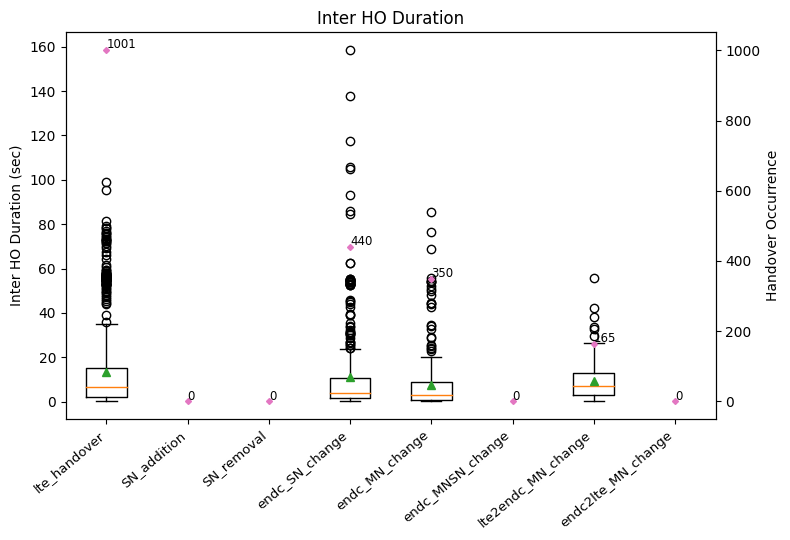

In [23]:
total_ho_occurrence_list = [len(lst) for lst in ho_duration_list]

# Plotting
# x = np.arange(len(dset))  # the label locations

fig, ax = plt.subplots(figsize=(8, 5.5))
ax.boxplot(ho_duration_list, showmeans=True)

ax.set_xticks(list(range(1, 9)), handover_types_0)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, fontsize=9.5, ha="right")

ax.set_title('Inter HO Duration')
ax.set_ylabel('Inter HO Duration (sec)')

ax2 = ax.twinx()
ax2.plot(list(range(1, 9)), total_ho_occurrence_list, c='tab:pink', linestyle='None', linewidth=1, marker='D', markersize=3)
ax2.set_ylabel('Handover Occurrence')
for i, txt in enumerate(total_ho_occurrence_list):
    ax2.annotate(str(total_ho_occurrence_list[i]), (list(range(1, 9))[i], total_ho_occurrence_list[i]+5), size=8.5)

fig.tight_layout()
fig.savefig(os.path.join(figdir, "5.png"), bbox_inches='tight')
plt.show()